<a href="https://colab.research.google.com/github/lefreire/mcmc/blob/master/mcmc_lista4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from numpy.linalg import matrix_power
import matplotlib.pyplot as plt

# Calculating stationary distribution
In this exercise, we are calculating stationary distribution $\pi$ for 3 graphs: ring, binary tree and grid. Also, we are calculating the error between $\pi(t)$ and $\pi$.

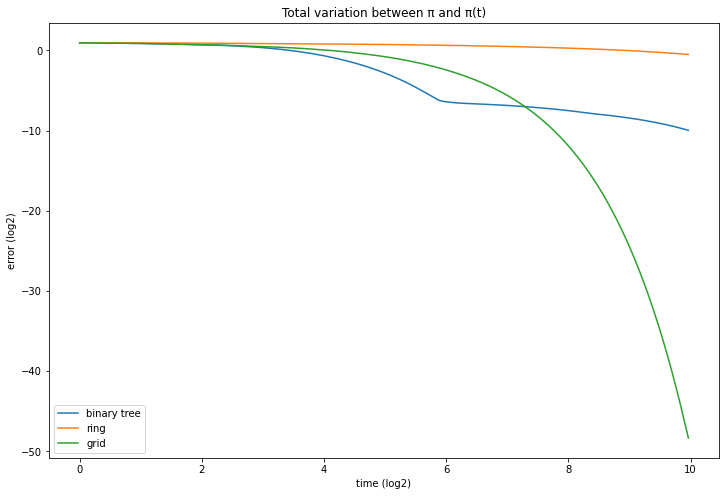

In [ ]:
#QUESTAO 3
#grafo em anel
def matrix_prob_ring(n=100):
  P = np.zeros((n, n))

  P[0][0] = 0.5
  P[0][-1] = 1/4
  P[0][1] = 1/4
  P[-1][0] = 1/4
  P[-1][-1] = 1/2
  P[-1][-2] = 1/4

  for i in range(1, n-1):
    P[i][i] = 0.5
    P[i][i-1] = P[i][i+1] = 1/4
  
  return P

#arvore binaria
def matrix_prob_bin_tree(n=100):
  levels = int(np.log2(n))

  P = np.zeros((n, n))
  P[0][0] = 0.5
  P[0][1] = P[0][2] = 1/4

  num_nodes = 1
  
  for level in range(1, levels):
    i = num_nodes
    while i <= num_nodes-1+2**level:
      P[i][i] = 0.5
      num_neigh = 1
      if (2*i)+1 < n:
        num_neigh += 1
      if (2*i)+2 < n:
        num_neigh += 1
      if num_neigh == 1:
        if i%2 == 0:
          P[i][int(i/2)-1] = 1/2
        else:
          P[i][int(i/2)] = 1/2
      if num_neigh == 2:
        P[i][(2*i)+1] = 1/4
        if i%2 == 0:
          P[i][int(i/2)-1] = 1/4
        else:
          P[i][int(i/2)] = 1/4
      if num_neigh == 3:
        P[i][(2*i)+1] = P[i][(2*i)+2] = 1/6
        if i%2 == 0:
          P[i][int(i/2)-1] = 1/6
        else:
          P[i][int(i/2)] = 1/6
      i += 1
    num_nodes += 2**level
  
  for i in range(2**(levels-1)+1, n):
    P[i][i] = 0.5
    if i%2 == 0:
      P[i][int(i/2)-1] = 1/2
    else:
      P[i][int(i/2)] = 1/2
    
  return P



#grafo em reticulado
def matrix_prob_graph_2d(n=100):
  #matrix needs to be k x k, so n needs to be a square number
  if not np.sqrt(n).is_integer():
    n = (int(np.sqrt(n))+1)**2
  
  num_rows = int(np.sqrt(n))
  P = np.zeros((n, n))

  for i in range(0, n):
    actual_row = int(i/num_rows)
    P[i][i] = 0.5
    P[i, actual_row*num_rows+(i+1)%num_rows] = 1/8
    P[i, actual_row*num_rows+(i-1)%num_rows] = 1/8
    P[i, (i+num_rows)%n] = 1/8
    P[i, (i-num_rows)%n] = 1/8

  return P


def dist_estacionaria(n=100, type_graph='ring'):
  if type_graph == 'ring':
    P = matrix_prob_ring(n)
  elif type_graph == 'tree':
    P = matrix_prob_bin_tree(n)
  elif type_graph == '2d':
    P = matrix_prob_graph_2d(n)

  all_edges = np.count_nonzero(P)-len(P)
  dist_estac = []
  for i in range(0, len(P)):
    dist_estac.append((np.count_nonzero(P[i][:])-1)/all_edges)
  return P, np.array(dist_estac)


def calculate_error(n=100, type_graph='ring'):
  P, dist = dist_estacionaria(n, type_graph)
  pi_zero = np.zeros(len(P))
  pi_zero[0] = 1

  rel_error = []
  res_mult = np.dot(pi_zero, P)
  diff = abs(dist-res_mult)
  rel_error.append(np.sum(diff))
  for t in range(2, 10**3):
    res_mult = np.dot(res_mult, P)
    diff = abs(dist-res_mult)
    rel_error.append(np.sum(diff))
  return rel_error

ering = calculate_error(n=128)
etree = calculate_error(128, type_graph='tree')
egrid = calculate_error(n=128, type_graph='2d')

plt.figure(figsize=(12,8))
plt.plot(np.log2(range(1, 10**3)), np.log2(etree),label='binary tree')
plt.plot(np.log2(range(1, 10**3)), np.log2(ering), label='ring')
plt.plot(np.log2(range(1, 10**3)), np.log2(egrid), label='grid')
plt.title("Total variation between π and π(t)")
plt.xlabel("time (log2)")
plt.ylabel("error (log2)")
plt.legend(loc="lower left")
plt.show()

# Calculating mixing time
This function calculates the mixing time $\tau_{\epsilon}$ for the same graphs. The mixing time calculates how many steps we need to stay $\epsilon$ close to the stationary distribution $\pi$.

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


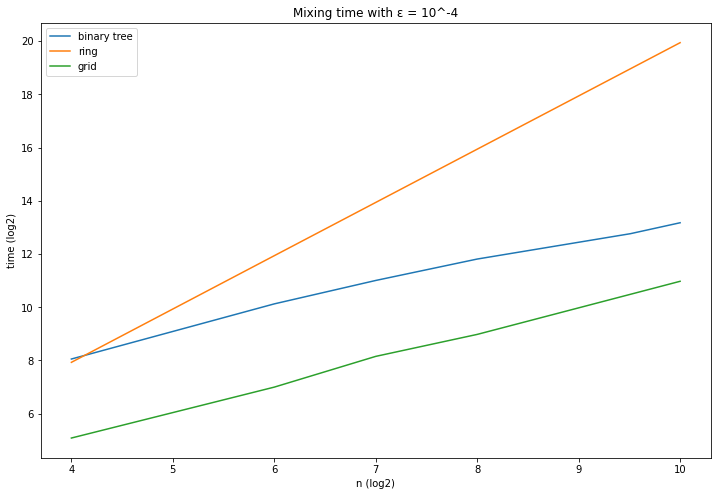

In [ ]:
#QUESTAO 4

def mix_time(n, type_graph='ring'):
  P, dist = dist_estacionaria(n, type_graph) 
  pi_zero = np.zeros(len(P))
  pi_zero[0] = 1

  epsilon = 10**-4

  rel_error = []
  _time = 1
  res_mult = np.dot(pi_zero, P)
  _diff = abs(dist-res_mult)
  while np.sum(_diff) > epsilon:
    _time += 1
    res_mult = np.dot(res_mult, P)
    _diff = abs(dist-res_mult)

  return _time


n = [16, 64, 128, 256, 729, 1024]
tring = []
ttree = []
tgraph = []
for i in n:
  ttree.append(mix_time(i, 'tree'))
  tgraph.append(mix_time(i, '2d'))
  tring.append(mix_time(i))
  
plt.figure(figsize=(12,8))
plt.plot(np.log2(n), np.log2(ttree),label='binary tree')
plt.plot(np.log2(n), np.log2(tring), label='ring')
plt.plot(np.log2(n), np.log2(tgraph), label='grid')
plt.title("Mixing time with ε = 10^-4")
plt.xlabel("n (log2)")
plt.ylabel("time (log2)")
plt.legend(loc="upper left")
plt.show()